# Potential-field continuation via equivalent layer

This code illustrates how to compute the up and downward continuation of gravity disturbance via equivalent layer.

### Things we have to import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gravmag import eqlayer, filters, transforms, convolve, utils, data_structures, inverse_distance
from gravmag.models import rectangular_prism as rp
from gravmag import plot_functions as plf
from gravmag import constants as cts

### Model

In [2]:
# Create a model formed by a single prism
model = {
    'x1' : np.array([ -500.]),
    'x2' : np.array([  500.]),
    'y1' : np.array([    0.]),
    'y2' : np.array([ 2000.]),
    'z1' : np.array([  150.]),
    'z2' : np.array([ 1010.]),
}

# density (km / m³
density = np.array([2000.])

### Points were we compute the synthetic data

In [3]:
# number of points along x and y
shape = (60, 61)

# minimum x, maximum x, minimum y and maximum y
area = [-5100, 4900, -3800, 6200]

# grid of computation points
coordinates_grid = data_structures.grid_xy(area=area, shape=shape, z0=-150)

In [4]:
# Grid spacing
dx, dy = data_structures.grid_xy_spacing(area, shape)

In [5]:
print(dx, dy)

169.4915254237288 166.66666666666666


### Synthetic gravity disturbance data

In [6]:
# compute the pseudogravity anomaly
grav_obs = rp.grav(
    coordinates=data_structures.grid_xy_to_full_flatten(
        grid=coordinates_grid,
        ordering='xy'
    ),
    prisms=model, 
    density=density, 
    field='z', 
    scale=True
)

In [7]:
# coordinates rearranged for plotting
# they are "views' of the original coordinates in 'coordinates_grid'
X, Y = data_structures.grid_xy_to_full_matrices_view(
    x = coordinates_grid['x'],
    y = coordinates_grid['y'],
    shape = coordinates_grid['shape']
)

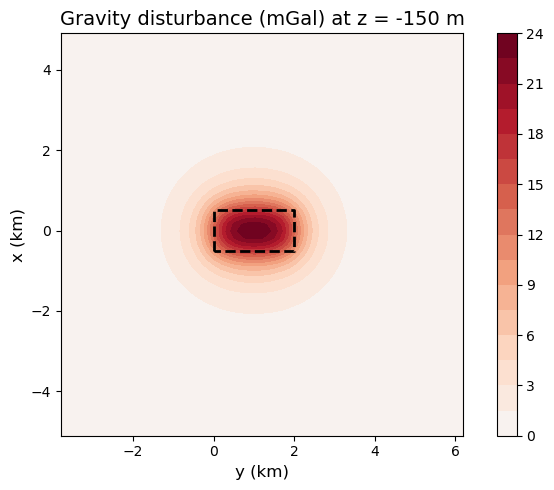

In [8]:
plt.figure(figsize=(7,5))

bounds = np.max(np.abs(grav_obs))

plt.title('Gravity disturbance (mGal) at z = {} m'.format(coordinates_grid['z']), fontsize=14)
plt.axis('scaled')
plt.contourf(
    Y*0.001, X*0.001,
    data_structures.grid_xy_full_flatten_to_matrix(
        data=grav_obs, ordering='xy', shape=coordinates_grid['shape']
    ),
    15,
    cmap='RdBu_r',
    vmin = -bounds, vmax = bounds
)
plt.colorbar()
plf.model_boundaries(model, m2km=True)
plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
plt.xlabel('y (km)', fontsize=12)
plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

### Estimate the equivalent layer

In [9]:
# set the layer plane
z_layer = 150.

In [10]:
# compute the sensibility matrix
R2 = inverse_distance.sedm_BTTB(
    data_grid = coordinates_grid, 
    delta_z = z_layer - coordinates_grid['z'],
    ordering = 'xy'
)

A = inverse_distance.grad_BTTB(
    data_grid = coordinates_grid,
    delta_z = z_layer - coordinates_grid['z'],
    SEDM = R2,
    ordering = 'xy',
    components=['z'],
)

# compute the eigenvalues matrix
L = convolve.eigenvalues_BCCB(BTTB_metadata=A['z'], ordering="row")

In [12]:
# estimate the equivalent layer
deltas, parameters = eqlayer.method_iterative_deconvolution_TOB20(
    eigenvalues_matrices = [L], 
    data_vectors = [grav_obs], 
    epsilon = 1e-5, 
    ITMAX = 50, 
    p0 = None
)

In [13]:
iterations = [i for i in range(len(deltas))]

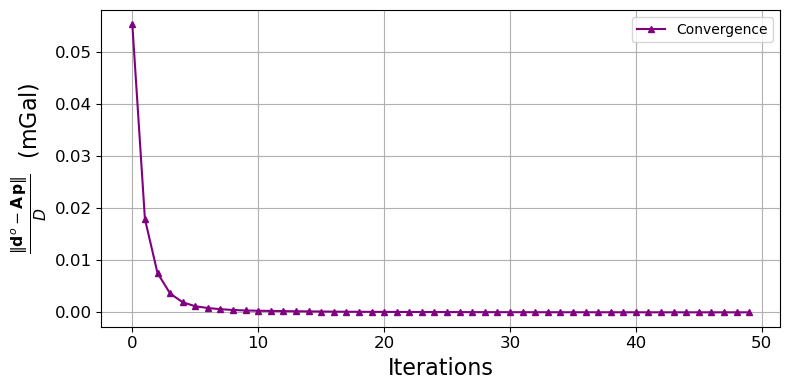

In [14]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(iterations, deltas, linestyle='-', 
        color='purple', marker='^', alpha=1, markersize=4, label='Convergence')

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_xlabel('Iterations', fontsize=16)
ax.set_ylabel('$\\frac{\Vert \mathbf{d}^{o} - \mathbf{A} \, \mathbf{p} \Vert}{D}$  (mGal)', fontsize=16)
ax.grid(True)
ax.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.show()

In [15]:
# data predicted by the estimated equivalent layer
predicted_data = convolve.product_BCCB_vector(
    eigenvalues=L, ordering="row", v=parameters
)

In [16]:
# residuals vector
residuals_data = predicted_data - grav_obs

### Plot the data fit

In [17]:
ranges_data = np.max(np.abs(grav_obs))
ranges_res = np.max(np.abs(residuals_data))

In [18]:
# coordinates rearranged for plotting
# they are "views' of the original coordinates in 'coordinates_grid'
X, Y = data_structures.grid_xy_to_full_matrices_view(
    x = coordinates_grid['x'],
    y = coordinates_grid['y'],
    shape = coordinates_grid['shape']
)

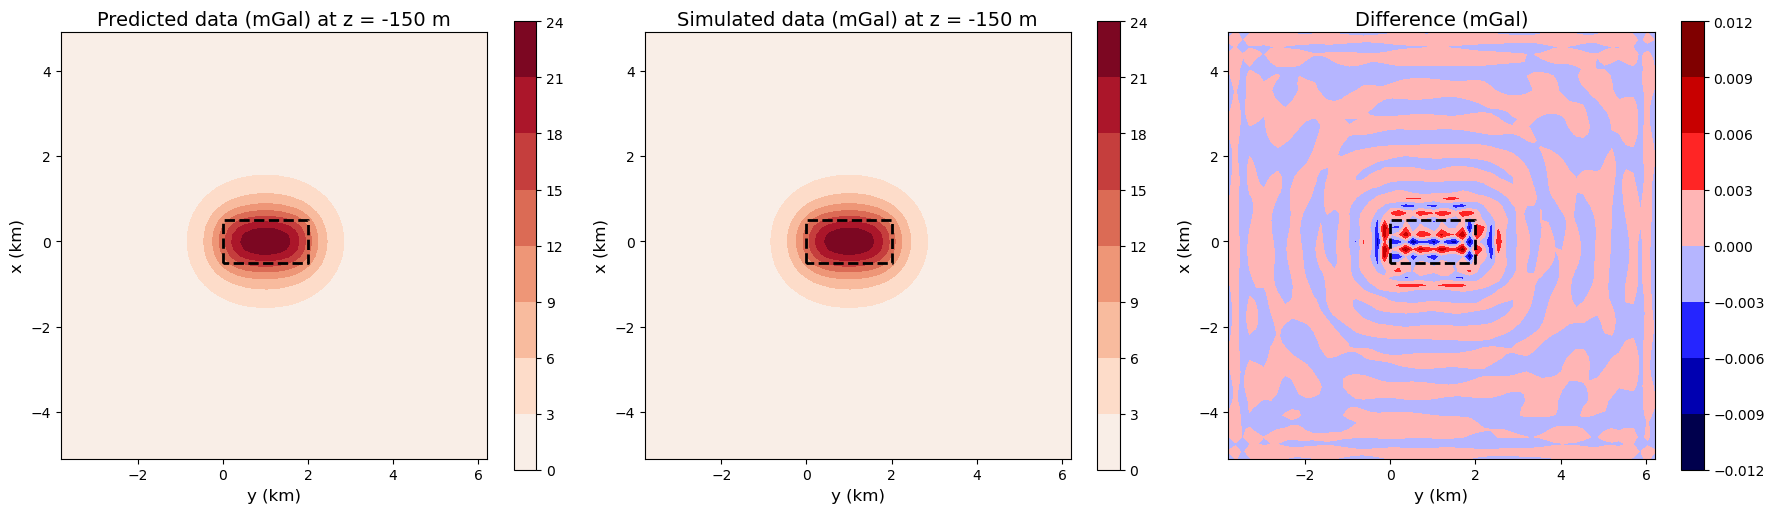

In [19]:
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.title('Predicted data (mGal) at z = {} m'.format(coordinates_grid['z']), fontsize=14)
plt.axis('scaled')
plt.contourf(
    Y*0.001, X*0.001,
    data_structures.grid_xy_full_flatten_to_matrix(
        data=predicted_data, ordering='xy', shape=coordinates_grid['shape']
    ),
    cmap='RdBu_r',
    vmin = -ranges_data, vmax = ranges_data
)
plt.colorbar()
plf.model_boundaries(model, m2km=True)
plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
plt.xlabel('y (km)', fontsize=12)
plt.ylabel('x (km)', fontsize=12)

plt.subplot(1,3,2)
plt.title('Simulated data (mGal) at z = {} m'.format(coordinates_grid['z']), fontsize=14)
plt.axis('scaled')
plt.contourf(
    Y*0.001, X*0.001,
    data_structures.grid_xy_full_flatten_to_matrix(
        data=grav_obs, ordering='xy', shape=coordinates_grid['shape']
    ),
    cmap='RdBu_r',
    vmin = -ranges_data, vmax = ranges_data
)
plt.colorbar()
plf.model_boundaries(model, m2km=True)
plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
plt.xlabel('y (km)', fontsize=12)
plt.ylabel('x (km)', fontsize=12)

plt.subplot(1,3,3)
plt.title('Difference (mGal)', fontsize=14)
plt.axis('scaled')
plt.contourf(
    Y*0.001, X*0.001,
    data_structures.grid_xy_full_flatten_to_matrix(
        data=residuals_data, ordering='xy', shape=coordinates_grid['shape']
    ),
    cmap='seismic',
    vmin = -ranges_res, vmax = ranges_res
)
plt.colorbar()
plf.model_boundaries(model, m2km=True)
plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
plt.xlabel('y (km)', fontsize=12)
plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

### Downward continuation

In [20]:
coordinates_grid['z']

-150

In [21]:
z_down = 0.

In [22]:
coordinates_grid['z'] = z_down

In [23]:
coordinates_grid['z']

0.0

In [24]:
# compute the pseudogravity anomaly
grav_down_true = rp.grav(
    coordinates=data_structures.grid_xy_to_full_flatten(
        grid=coordinates_grid,
        ordering='xy'
    ),
    prisms=model, 
    density=density, 
    field='z', 
    scale=True
)

In [25]:
coordinates_grid['z'] = -150

In [26]:
coordinates_grid['z']

-150

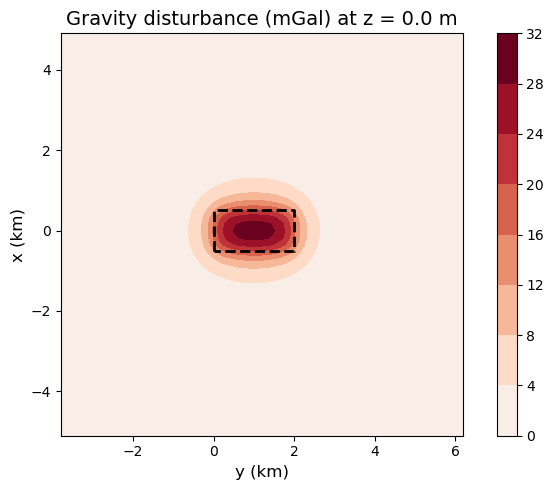

In [27]:
plt.figure(figsize=(7,5))

bounds = np.max(np.abs(grav_down_true))

plt.title('Gravity disturbance (mGal) at z = {} m'.format(z_down), fontsize=14)
plt.axis('scaled')
plt.contourf(
    Y*0.001, X*0.001,
    data_structures.grid_xy_full_flatten_to_matrix(
        data=grav_down_true, ordering='xy', shape=coordinates_grid['shape']
    ),
    cmap='RdBu_r',
    vmin = -bounds, vmax = bounds
)
plt.colorbar()
plf.model_boundaries(model, m2km=True)
plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
plt.xlabel('y (km)', fontsize=12)
plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

In [28]:
# compute the sensibility matrix
R2 = inverse_distance.sedm_BTTB(
    data_grid = coordinates_grid, 
    delta_z = z_layer - z_down,
    ordering = 'xy'
)

A = inverse_distance.grad_BTTB(
    data_grid = coordinates_grid,
    delta_z = z_layer - z_down,
    SEDM = R2,
    ordering = 'xy',
    components=['z'],
)

# compute the eigenvalues matrix
L = convolve.eigenvalues_BCCB(BTTB_metadata=A['z'], ordering="row")

In [29]:
# data predicted by the estimated equivalent layer
grav_down_cont = convolve.product_BCCB_vector(
    eigenvalues=L, ordering="row", v=parameters
)

In [30]:
# differences
differences = grav_down_cont - grav_down_true

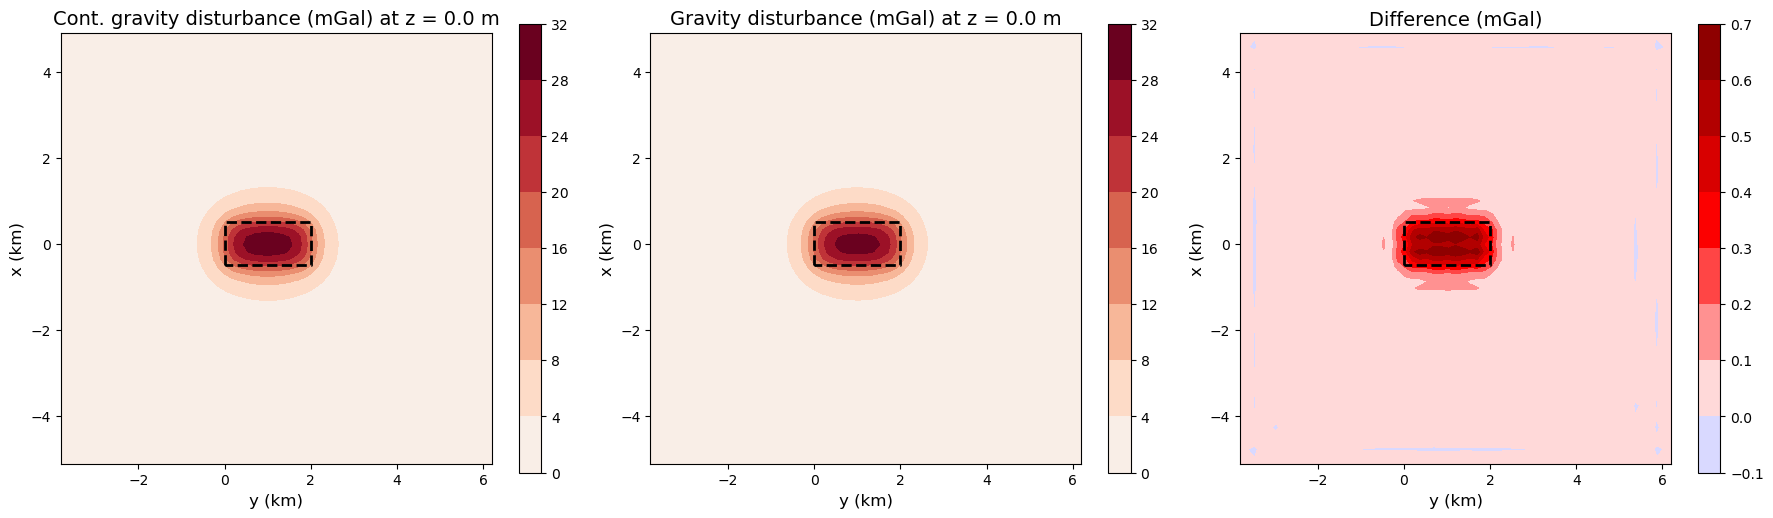

In [31]:
plt.figure(figsize=(18,5))

# set the same scale of the true field at z = 100 m
bounds = np.max(np.abs(grav_down_true))

plt.subplot(1,3,1)
plt.title('Cont. gravity disturbance (mGal) at z = {} m'.format(z_down), fontsize=14)
plt.axis('scaled')
plt.contourf(
    Y*0.001, X*0.001,
    data_structures.grid_xy_full_flatten_to_matrix(
        data=grav_down_cont, ordering='xy', shape=coordinates_grid['shape']
    ),
    cmap='RdBu_r',
    vmin = -bounds, vmax = bounds
)
plt.colorbar()
plf.model_boundaries(model, m2km=True)
plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
plt.xlabel('y (km)', fontsize=12)
plt.ylabel('x (km)', fontsize=12)

plt.subplot(1,3,2)
plt.title('Gravity disturbance (mGal) at z = {} m'.format(z_down), fontsize=14)
plt.axis('scaled')
plt.contourf(
    Y*0.001, X*0.001,
    data_structures.grid_xy_full_flatten_to_matrix(
        data=grav_down_true, ordering='xy', shape=coordinates_grid['shape']
    ),
    cmap='RdBu_r',
    vmin = -bounds, vmax = bounds
)
plt.colorbar()
plf.model_boundaries(model, m2km=True)
plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
plt.xlabel('y (km)', fontsize=12)
plt.ylabel('x (km)', fontsize=12)

plt.subplot(1,3,3)

# set the same scale of the true field at z = 100 m
bounds_diff = np.max(np.abs(differences))

plt.title('Difference (mGal)', fontsize=14)
plt.axis('scaled')
plt.contourf(
    Y*0.001, X*0.001,
    data_structures.grid_xy_full_flatten_to_matrix(
        data=differences, ordering='xy', shape=coordinates_grid['shape']
    ),
    cmap='seismic',
    vmin = -bounds_diff, vmax = bounds_diff
)
plt.colorbar()
plf.model_boundaries(model, m2km=True)
plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
plt.xlabel('y (km)', fontsize=12)
plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

### Upward continuation

In [32]:
coordinates_grid['z']

-150

In [33]:
z_up = -400.

In [34]:
coordinates_grid['z'] = z_up

In [35]:
coordinates_grid['z']

-400.0

In [36]:
# compute the pseudogravity anomaly
grav_up_true = rp.grav(
    coordinates=data_structures.grid_xy_to_full_flatten(
        grid=coordinates_grid,
        ordering='xy'
    ),
    prisms=model, 
    density=density, 
    field='z', 
    scale=True
)

In [37]:
coordinates_grid['z'] = -150

In [38]:
coordinates_grid['z']

-150

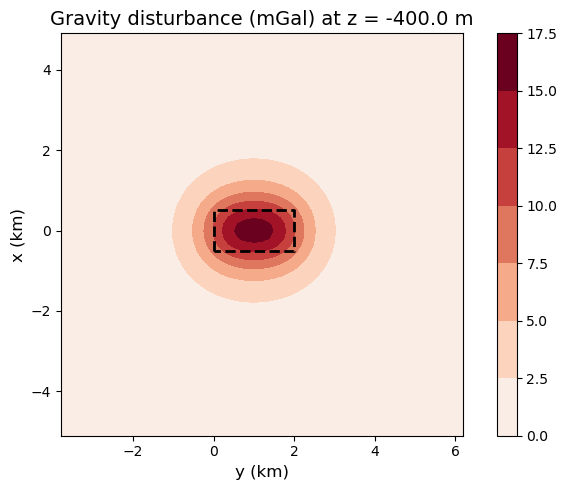

In [39]:
plt.figure(figsize=(7,5))

bounds = np.max(np.abs(grav_up_true))

plt.title('Gravity disturbance (mGal) at z = {} m'.format(z_up), fontsize=14)
plt.axis('scaled')
plt.contourf(
    Y*0.001, X*0.001,
    data_structures.grid_xy_full_flatten_to_matrix(
        data=grav_up_true, ordering='xy', shape=coordinates_grid['shape']
    ),
    cmap='RdBu_r',
    vmin = -bounds, vmax = bounds
)
plt.colorbar()
plf.model_boundaries(model, m2km=True)
plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
plt.xlabel('y (km)', fontsize=12)
plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

In [40]:
# compute the sensibility matrix
R2 = inverse_distance.sedm_BTTB(
    data_grid = coordinates_grid, 
    delta_z = z_layer - z_up,
    ordering = 'xy'
)

A = inverse_distance.grad_BTTB(
    data_grid = coordinates_grid,
    delta_z = z_layer - z_up,
    SEDM = R2,
    ordering = 'xy',
    components=['z'],
)

# compute the eigenvalues matrix
L = convolve.eigenvalues_BCCB(BTTB_metadata=A['z'], ordering="row")

In [41]:
# data predicted by the estimated equivalent layer
grav_up_cont = convolve.product_BCCB_vector(
    eigenvalues=L, ordering="row", v=parameters
)

In [42]:
# differences
differences = grav_up_cont - grav_up_true

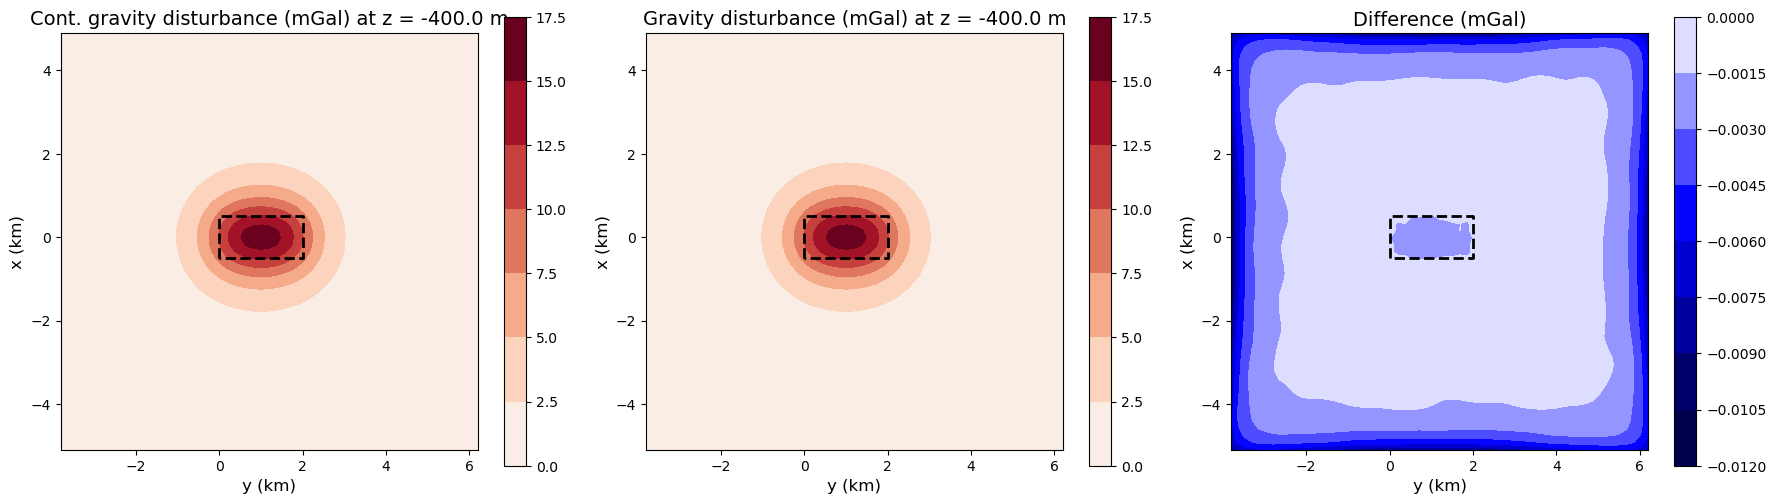

In [43]:
plt.figure(figsize=(18,5))

# set the same scale of the true field at z = 100 m
bounds = np.max(np.abs(grav_up_true))

plt.subplot(1,3,1)
plt.title('Cont. gravity disturbance (mGal) at z = {} m'.format(z_up), fontsize=14)
plt.axis('scaled')
plt.contourf(
    Y*0.001, X*0.001,
    data_structures.grid_xy_full_flatten_to_matrix(
        data=grav_up_cont, ordering='xy', shape=coordinates_grid['shape']
    ),
    cmap='RdBu_r',
    vmin = -bounds, vmax = bounds
)
plt.colorbar()
plf.model_boundaries(model, m2km=True)
plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
plt.xlabel('y (km)', fontsize=12)
plt.ylabel('x (km)', fontsize=12)

plt.subplot(1,3,2)
plt.title('Gravity disturbance (mGal) at z = {} m'.format(z_up), fontsize=14)
plt.axis('scaled')
plt.contourf(
    Y*0.001, X*0.001,
    data_structures.grid_xy_full_flatten_to_matrix(
        data=grav_up_true, ordering='xy', shape=coordinates_grid['shape']
    ),
    cmap='RdBu_r',
    vmin = -bounds, vmax = bounds
)
plt.colorbar()
plf.model_boundaries(model, m2km=True)
plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
plt.xlabel('y (km)', fontsize=12)
plt.ylabel('x (km)', fontsize=12)

plt.subplot(1,3,3)

# set the same scale of the true field at z = 100 m
bounds_diff = np.max(np.abs(differences))

plt.title('Difference (mGal)', fontsize=14)
plt.axis('scaled')
plt.contourf(
    Y*0.001, X*0.001,
    data_structures.grid_xy_full_flatten_to_matrix(
        data=differences, ordering='xy', shape=coordinates_grid['shape']
    ),
    cmap='seismic',
    vmin = -bounds_diff, vmax = bounds_diff
)
plt.colorbar()
plf.model_boundaries(model, m2km=True)
plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
plt.xlabel('y (km)', fontsize=12)
plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()